# Initial Exploration

## Problem description

Let f(x, P) be a neural network with fixed structure that takes as input a feature vector x and computes a real-valued output based on learnable parameters P.  Suppose that in response to a training example, the parameters are updated to P'.  The difference between the value of the function before and after the update is:

f(x, P) - f(x, P')

We would like a network that generalizes in the neighborhood of x.  That is, if x' is an input vector “close” to x, we would like the change in f due to the change in P at x to be similar in sign and magnitude to the change in f at x' due to the change in P.  The latter quantity can be written:

f(x', P) - f(x', P')

They are similar if the following loss is _all:

L\_gen = ((f(x, P) - f(x, P')) - (f(x', P) - f(x', P'))^2

If I update the parameters from P to P', the change in f should be similar in the neighborhood of x.  As |x - x'| gets larger, the neighborhood of the generalization increases.

Our goal is to pre-train a network using unlabeled data to get into a part of the parameter space such that generalization during pre-training is broad, thereby leading to faster convergence.  Consider the following algorithmic approach to this idea.


```
Input: X = {x1, x2, , xn}, neural network f, x, P
x is the standard deviation of the noise applied to x
p is the standard deviation of the noise applied to P

While not converged
  Choose x from X at random
  x’ = x + N(0, x)
  P’ = P + N(0, P)
  Compute derivative of  Lgen wrt P
  Update P using gradient descent

Return P
```gradient descent

Return P


In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
class TinyModel(nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 30),
            nn.ReLU(),
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
class SineDataset(Dataset):
    # Implement noise later
    def __init__(self, num_samples, start=0, stop=2*math.pi, include_noise=False):
        self.num_samples = num_samples
        self.start = start
        self.stop = start

        pts = np.linspace(start, stop, num_samples)
        self.data = torch.from_numpy(pts).to(torch.float32)
        self.labels = torch.sin(self.data).to(torch.float32)
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def get_data(self):
        return self.data

    def get_labels(self):
        return self.labels
        

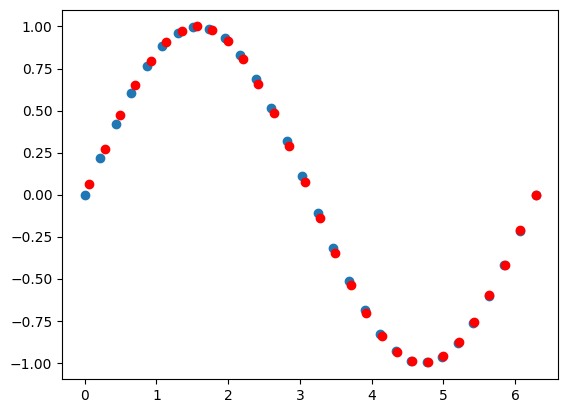

In [4]:
train_data = SineDataset(30)
test_data = SineDataset(30, start = math.pi/50)
plt.scatter(train_data.get_data().numpy(), train_data.get_labels().numpy())
plt.scatter(test_data.get_data().numpy(), test_data.get_labels().numpy(), color='red')

train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [5]:
learning_rate = 1e-2
epochs = 140

sin_model = TinyModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(sin_model.parameters(), lr=learning_rate)

In [6]:
# Taken from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html and somewhat altered
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    total_loss = 0
    batches = 0
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
        #if batch % 100 == 0:
            #loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return total_loss / batches

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    xs = []
    ys = []
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            xs.append(X.item())
            preds.append(pred.item())
            ys.append(y.item())
            test_loss += loss_fn(pred, y).item()
    #fig, ax = plt.subplots()
    plt.scatter(xs, ys, label="True points")
    plt.scatter(xs, preds, label="Predictions")
    plt.legend()

    plt.show()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [7]:
# Based off Mohammad M's initial code sample
def nbd_loss(a, b, c, d):
    return torch.sum(((a-b) - (c-d))**2)

def precond_loop(network, network_prime, dataloader, four_loss, optimizer):

    for batch, (X, y) in enumerate(dataloader):

        optimizer.zero_grad()
        x_prime = X + torch.normal(0, 0.05, X.shape)
        
        param_prime = {}
        for name, p in network.state_dict().items():
            param_prime[name] = p.clone() + torch.normal(0, 0.1, p.shape)
            param_prime[name].requires_grad = False
        network_prime.load_state_dict(param_prime)

        # forward 1: f(x, p)
        y_x_p = network(X)
        # forward 2: f(x', p)
        y_xp_p = network(x_prime)
        # forward 3: f(x, p')
        y_x_pp = network_prime(X)
        # forward 4: f(x', p')
        y_xp_pp = network_prime(x_prime)
        
        loss = four_loss(y_x_p, y_x_pp, y_xp_p, y_xp_pp)
        
        # backward: calculating the gradients w.r.t. p. Gradients of p' is turned off in line 44
        loss.backward()
        # update weights
        optimizer.step()
        return loss.item()

Epoch: 1


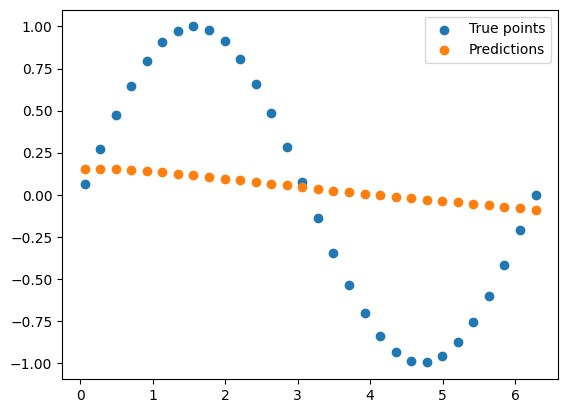

Avg loss: 0.410058 

Epoch: 2


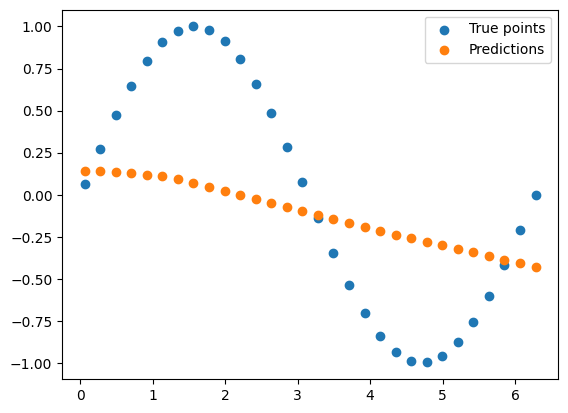

Avg loss: 0.331620 

Epoch: 3


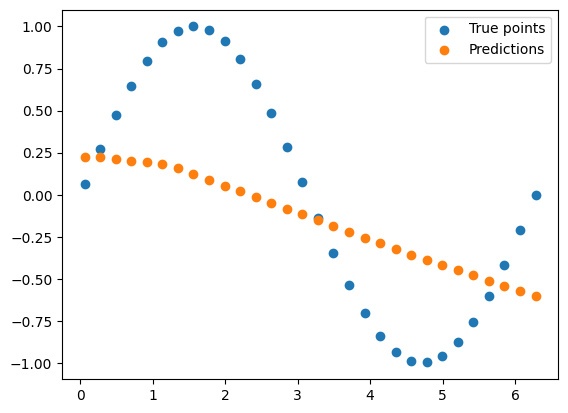

Avg loss: 0.284215 

Epoch: 4


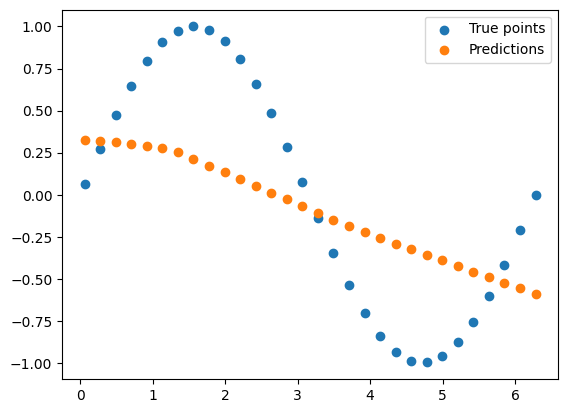

Avg loss: 0.253353 

Epoch: 5


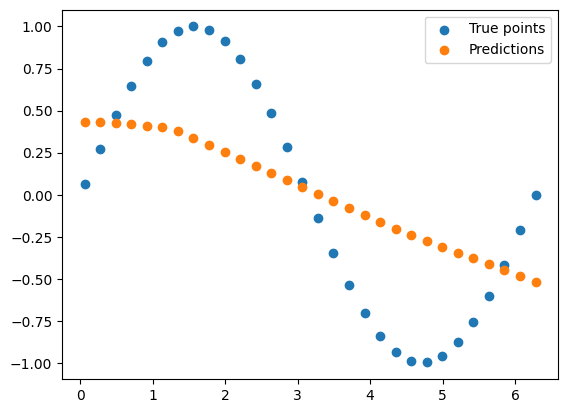

Avg loss: 0.234232 

Epoch: 6


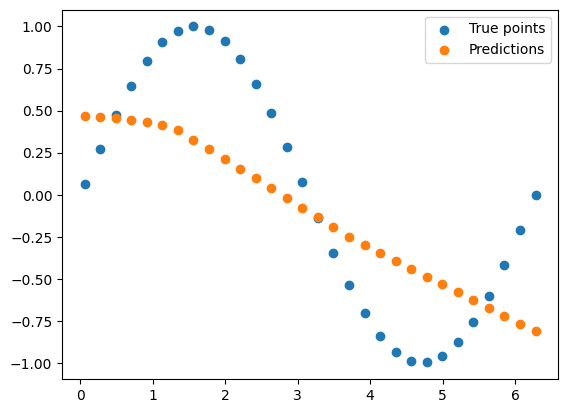

Avg loss: 0.206264 

Epoch: 7


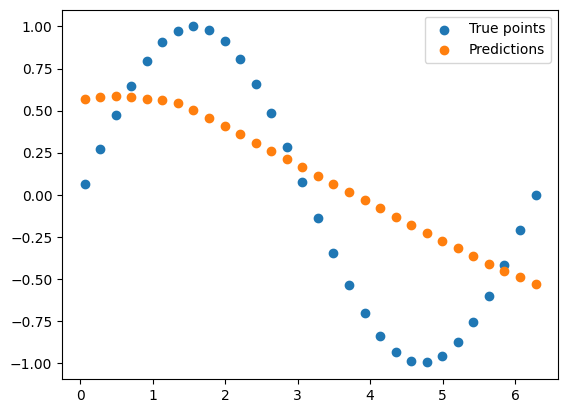

Avg loss: 0.222678 

Epoch: 8


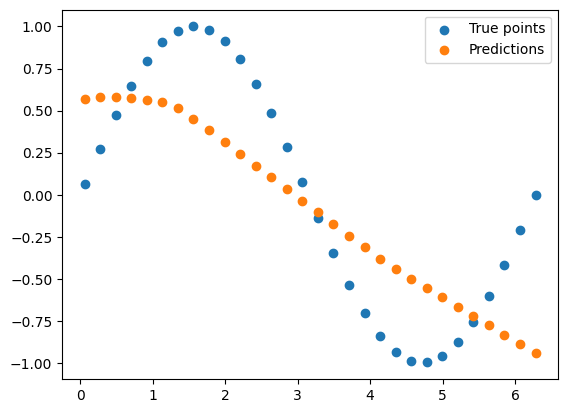

Avg loss: 0.180785 

Epoch: 9


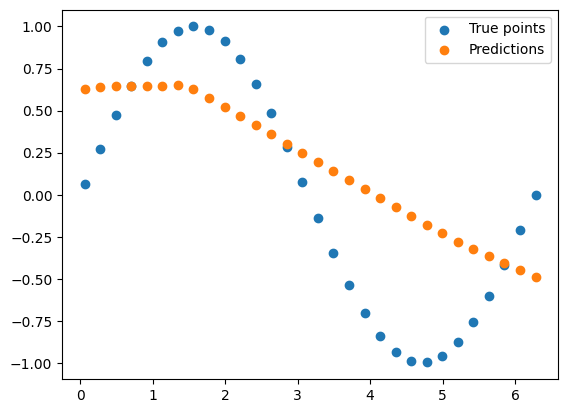

Avg loss: 0.229266 

Epoch: 10


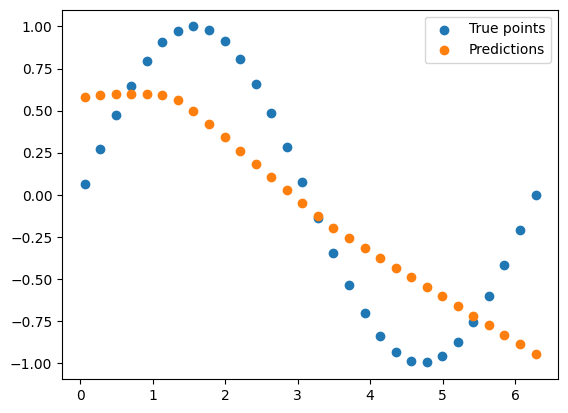

Avg loss: 0.174488 

Epoch: 11


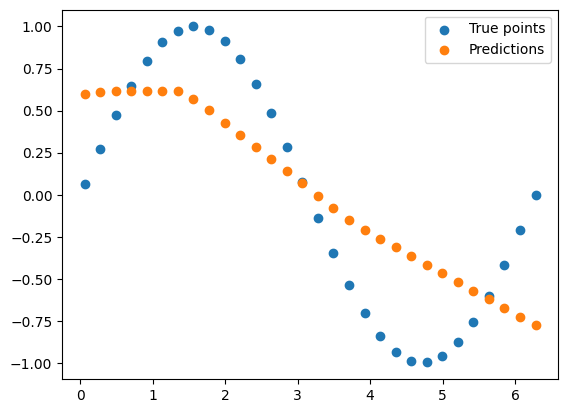

Avg loss: 0.167428 

Epoch: 12


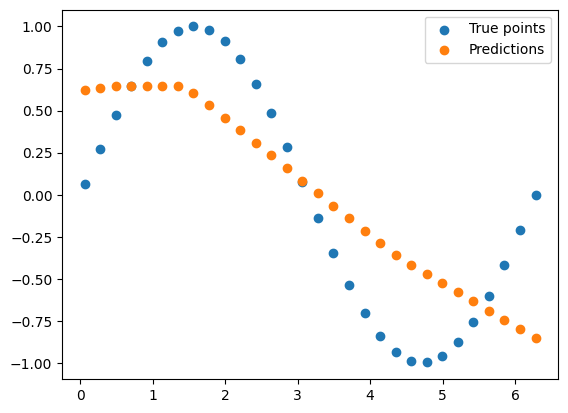

Avg loss: 0.161155 

Epoch: 13


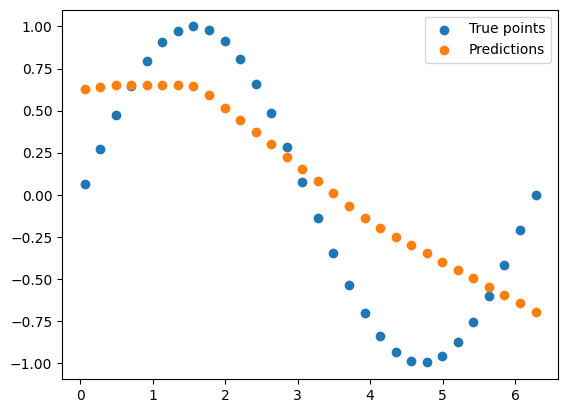

Avg loss: 0.171097 

Epoch: 14


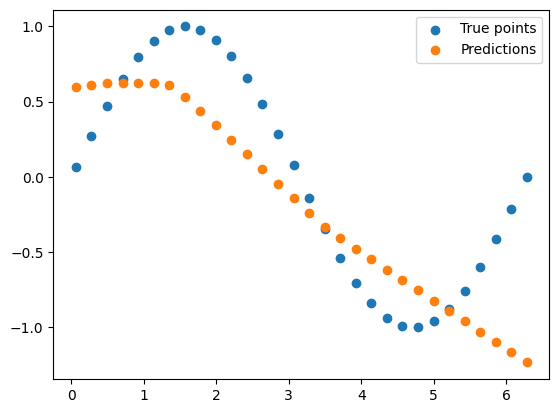

Avg loss: 0.199152 

Epoch: 15


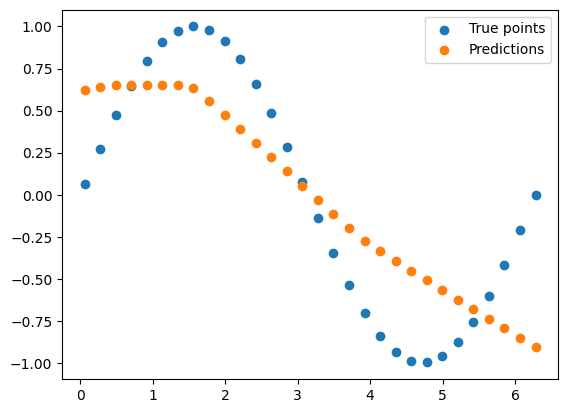

Avg loss: 0.153763 

Epoch: 28


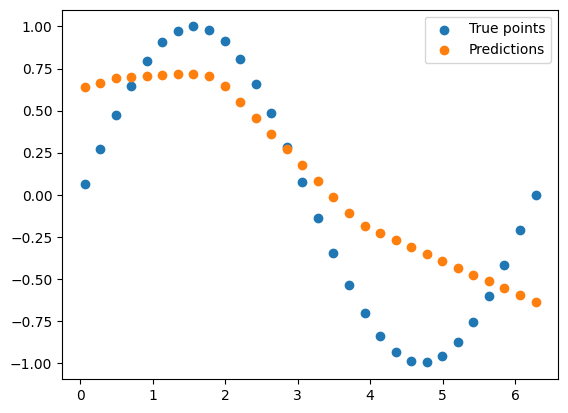

Avg loss: 0.149471 

Epoch: 56


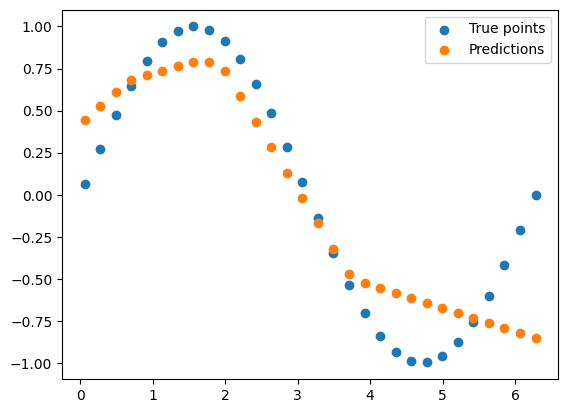

Avg loss: 0.083081 

Epoch: 84


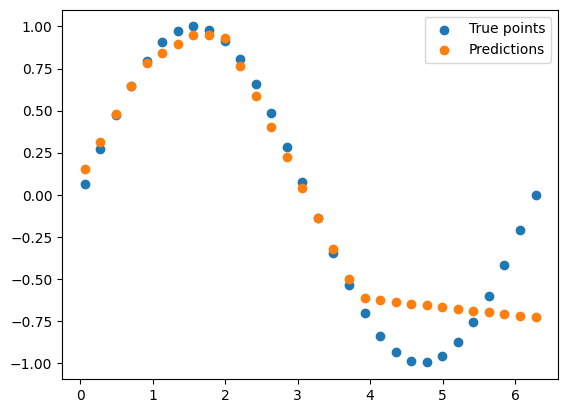

Avg loss: 0.047668 

Epoch: 112


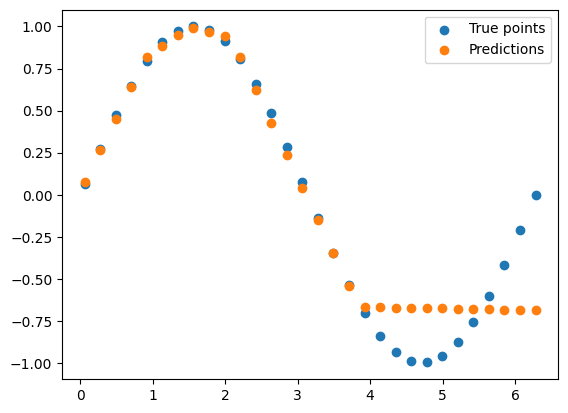

Avg loss: 0.040507 

Epoch: 140


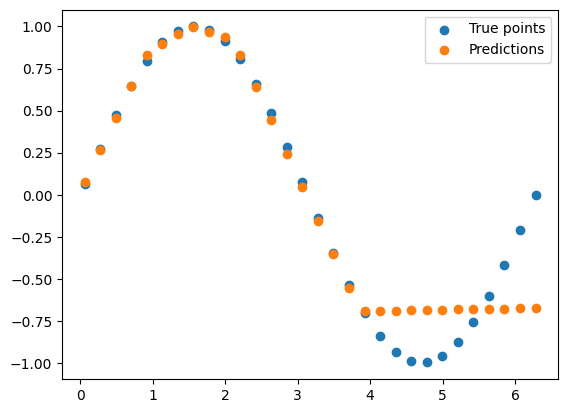

Avg loss: 0.038235 

Done!


In [8]:
standard_train_losses = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    standard_train_losses.append(train_loop(train_dataloader, sin_model, loss_function, optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, sin_model, loss_function)
print("Done!")

In [9]:
# Pretraining:
precond_epochs = 100
precond_network = TinyModel()
precond_prime_net = TinyModel()

precond_lr = 5e-3
precond_optimizer = torch.optim.SGD(precond_network.parameters(), lr=precond_lr)
training_optimizer = torch.optim.SGD(precond_network.parameters(), lr=learning_rate)

precond_losses = []
precond_training_losses = []

Epoch: 1


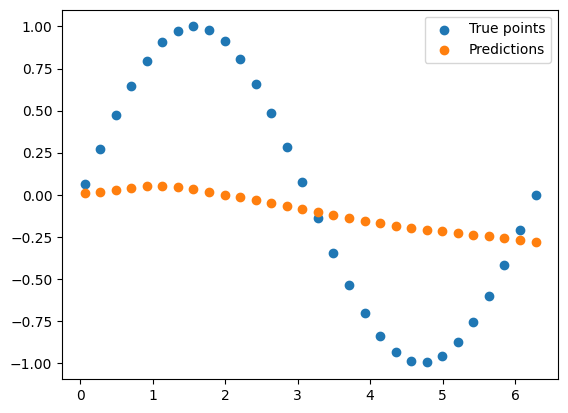

Avg loss: 0.376979 

Epoch: 2


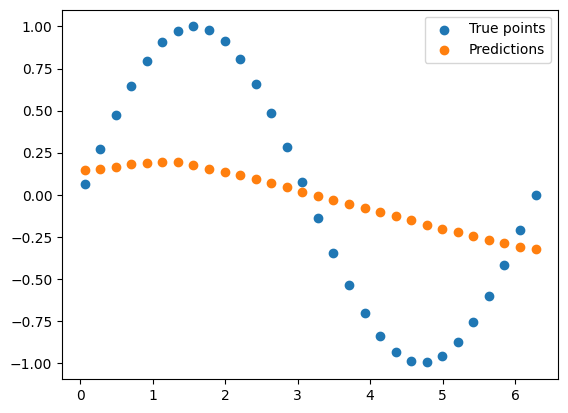

Avg loss: 0.320826 

Epoch: 3


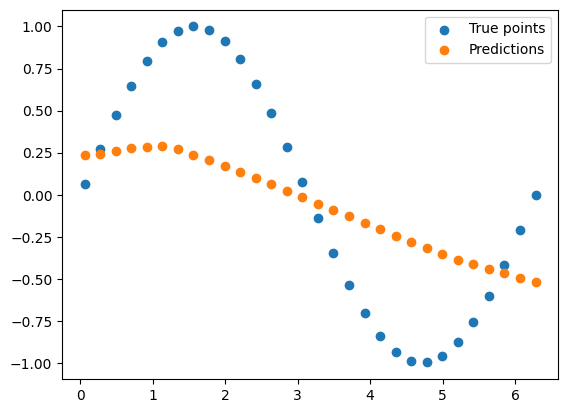

Avg loss: 0.252552 

Epoch: 4


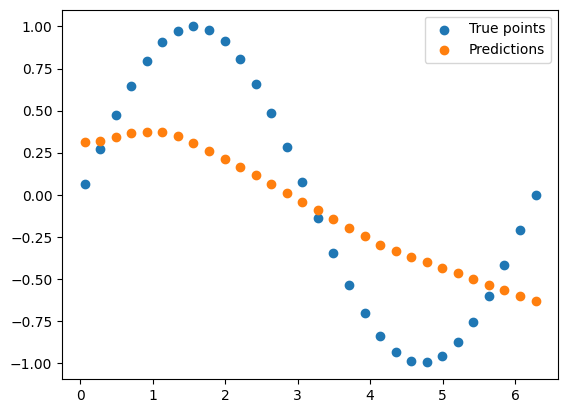

Avg loss: 0.210703 

Epoch: 5


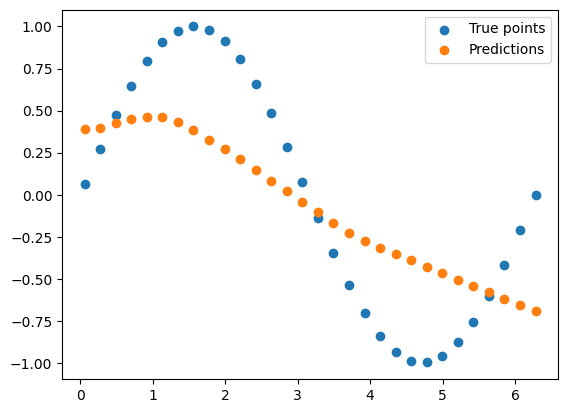

Avg loss: 0.186924 

Epoch: 6


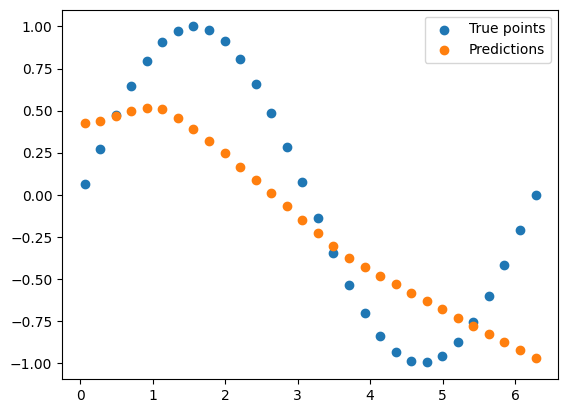

Avg loss: 0.186546 

Epoch: 7


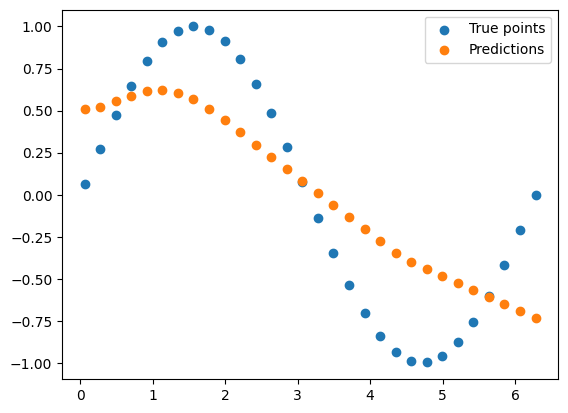

Avg loss: 0.153330 

Epoch: 8


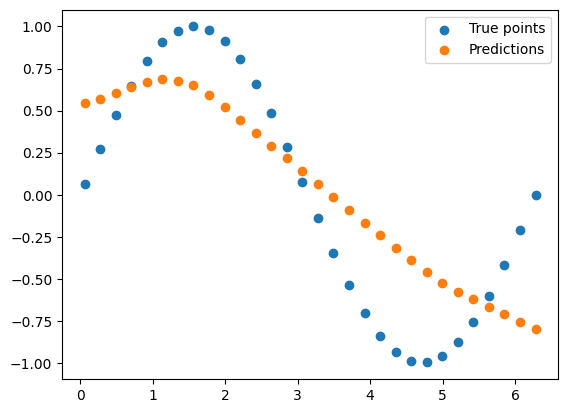

Avg loss: 0.151080 

Epoch: 9


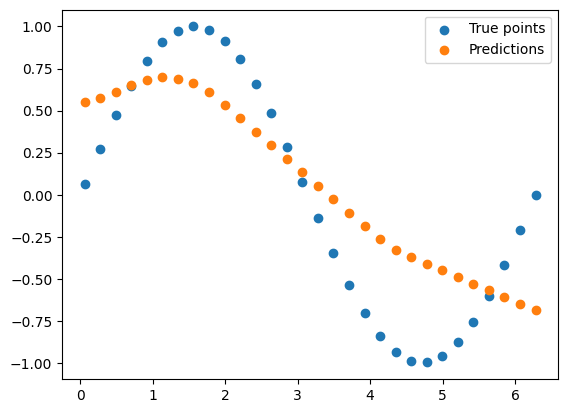

Avg loss: 0.143825 

Epoch: 10


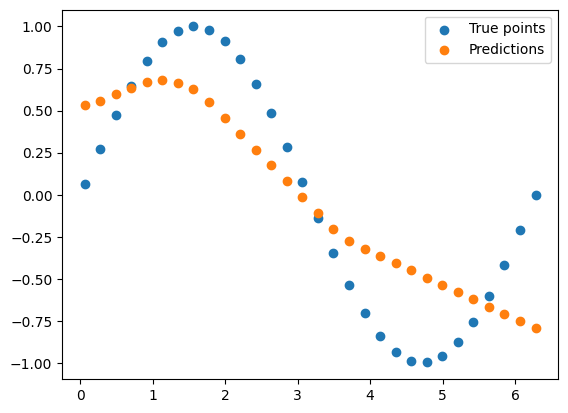

Avg loss: 0.136406 

Epoch: 11


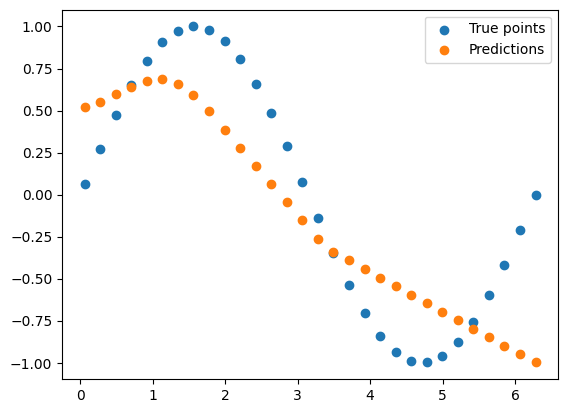

Avg loss: 0.152386 

Epoch: 12


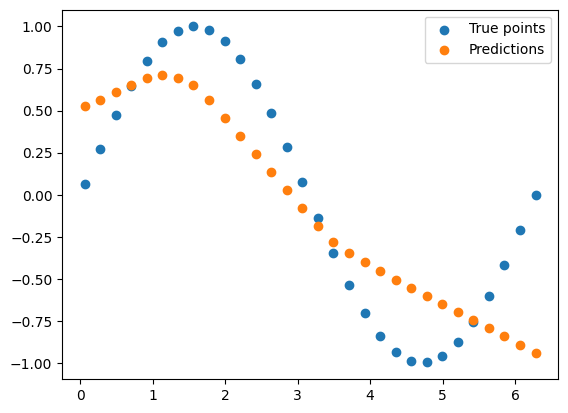

Avg loss: 0.134821 

Epoch: 13


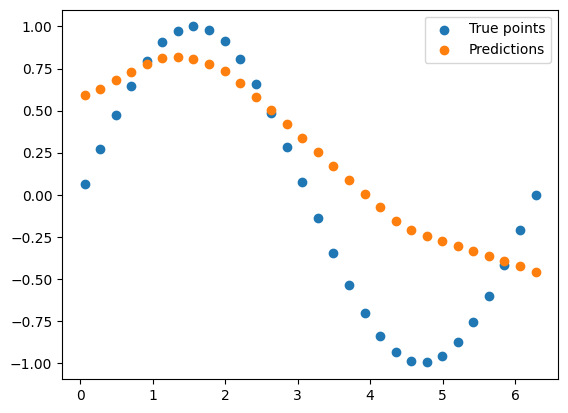

Avg loss: 0.189243 

Epoch: 14


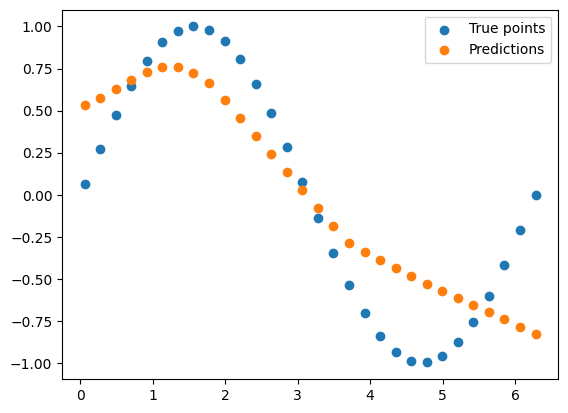

Avg loss: 0.117557 

Epoch: 15


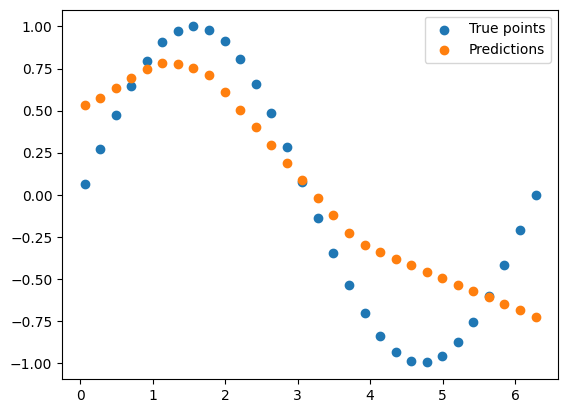

Avg loss: 0.116279 

Epoch: 28


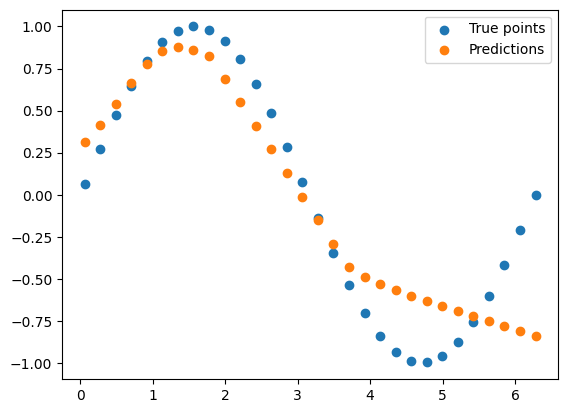

Avg loss: 0.077322 

Epoch: 56


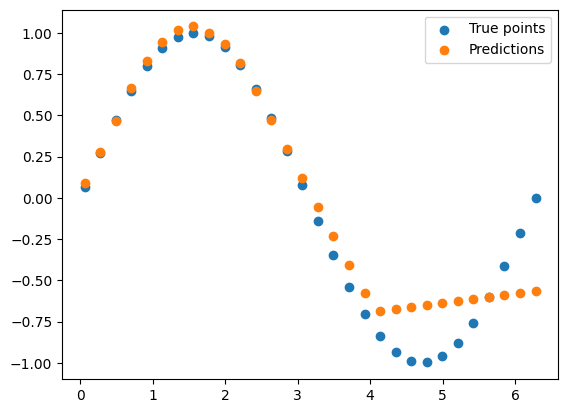

Avg loss: 0.035240 

Epoch: 84


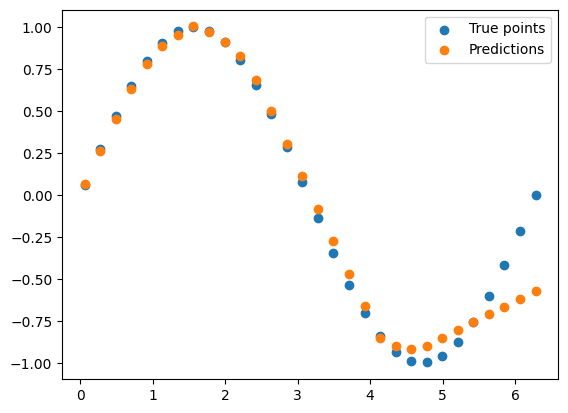

Avg loss: 0.020716 

Epoch: 112


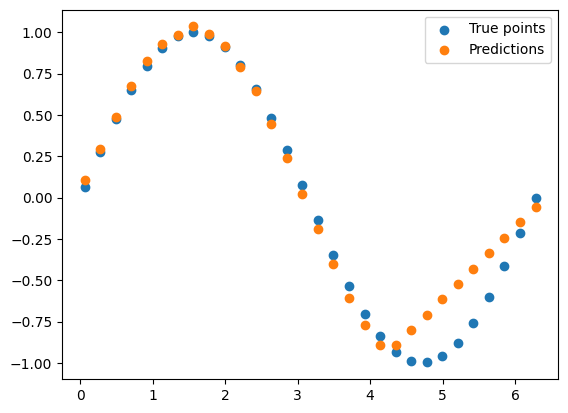

Avg loss: 0.020296 

Epoch: 140


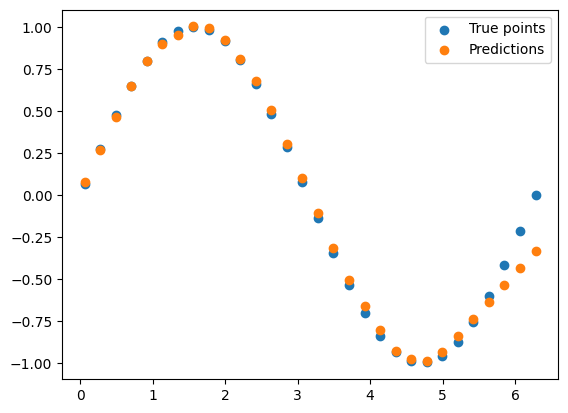

Avg loss: 0.006320 

Done!


In [10]:
for t in range(precond_epochs):
    precond_losses.append(precond_loop(precond_network, precond_prime_net, train_dataloader, nbd_loss, precond_optimizer))   

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    precond_training_losses.append(train_loop(train_dataloader, precond_network, loss_function, training_optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, precond_network, loss_function)
print("Done!")

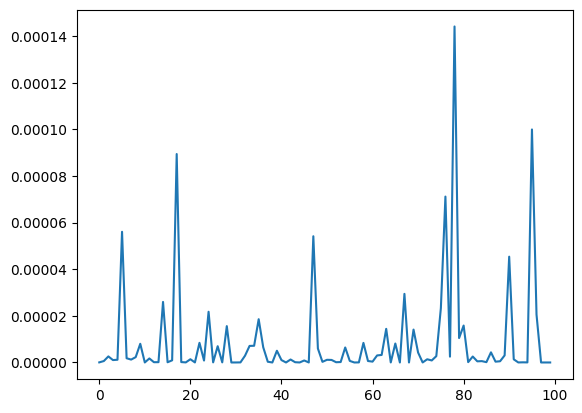

In [11]:
plt.plot(list(range(precond_epochs)), precond_losses)

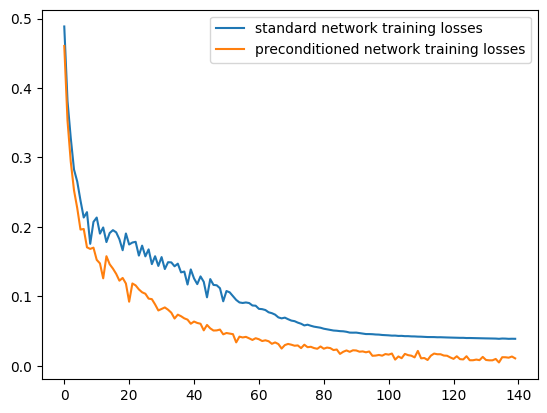

In [12]:
plt.plot(list(range(epochs)), standard_train_losses, label="standard network training losses")
plt.plot(list(range(epochs)), precond_training_losses, label="preconditioned network training losses")
plt.legend()